# Diffeomorphism-Invariant Observables on a 1D Periodic Lattice

## Overview

This notebook computes diffeomorphism-invariant observables of a free massive scalar field defined on a 1D superposition of lattices (or variable edge lengths) with peridical boundary conditions.

It evaluates:

- Expectation values of **edge lengths** ⟨ℓ⟩ and ⟨ℓ²⟩
- Expectation values of **lattice volume** ⟨V⟩ and ⟨V²⟩
- Two-point correlation functions ⟨φ_i φ_j⟩ as a function of **geodesic distance** (diffeo-invariant observable proposal)

The code uses a **Gaussian distribution** on edge lengths and includes **rotational symmetry reduction** (unique configurations under cyclic rotations).

---

## Main Functions

1. `observable(peak, sigma, XS, mass, dimen, spacing, num_bins)`
   - Computes the partition function
   - Calculates expectation values and correlation functions
   - Saves results to a file
   - Returns `d_vals, corr_vals` for plotting

2. `plot_correlation(d_vals, corr_vals; label="", color=:blue)`
   - Plots two-point correlation functions

3. Supporting functions:
   - `k_matrix`, `shiftup`, `shiftdown`, `distance`, `distribution`, etc.
   - Handle geometry, K-matrix inversion, and path weights

---

## Free Parameters

| Parameter     | Description |
|---------------|-------------|
| `XS`          | Number of edges (sites) of the 1D periodic lattice |
| `mass`        | Scalar field mass parameter |
| `peak`        | Mean of the Gaussian distribution for edge lengths |
| `sigma`       | Standard deviation of the Gaussian distribution |
| `dimen`       | Number of discrete samples per edge length (integration resolution) |
| `min_length`  | Minimum allowed edge length |
| `max_length`  | Maximum allowed edge length |
| `spacing`     | Step size for discrete lengths, Δℓ = (max_length - min_length)/dimen |
| `num_bins`    | Number of bins for correlation distance grouping |

---

## Workflow

1. Set free parameters
2. Run `observable(...)` to compute observables
3. Save results automatically to a text file
4. Plot results using `plot_correlation(...)`
5. Optional: adjust parameters, rerun, and compare multiple datasets


## ⚠️ Computational Complexity Warning

**Important:** The computational cost of this code scales exponentially with the lattice size and the discretization: $ \text{dimen}^{XS} $.

- For large `XS` (number of lattice edges) or large `dimen` (discretization points per edge), the runtime increases **very quickly**.  
- For reference, previous runs (taking a couple of days) were performed on an **HP cluster** Draco with:
  - `XS = 5`
  - `dimen ~ 100`
  
Running significantly larger values on a typical personal computer may **take days or be infeasible**.  
Adjust parameters accordingly and consider using HPC resources for large scans.



In [34]:
using LinearAlgebra
using Printf
using Plots
gr()
using LaTeXStrings


In [3]:
"""
Identity mapping for lattice index.
Kept for interface consistency and possible future extensions to bigger dimensions
"""
function toIndex(x, XS)
    return x
end


"""
Periodic forward shift on a lattice of size `NS`.
"""
function shiftup(num, NS)
    return (num % NS) + 1
end


"""
Periodic backward shift on a lattice of size `NS`.
"""
function shiftdown(num, NS)
    return (num - 2 + NS) % NS + 1
end


"""
Maps index `NS → 1`, otherwise returns `num`.
"""
function shift(num, NS)
    idx = num == NS ? 1 : num
    return idx
end


shift

In [10]:
"""
    is_unique_under_rotation(config, n)

Checks whether a configuration is the lexicographically smallest
among all its cyclic rotations (to exploid periodical boundary conditions, reducing computations).
"""
function is_unique_under_rotation(config, n)

    min_rotation = config

    for rotation in 1:n
        rotated = [config[(j + rotation - 1) % n + 1] for j in 1:n]
        if rotated < min_rotation
            min_rotation = rotated
        end
    end

    return config == min_rotation
end


"""
    unique_arrange(lst)

Returns true if all elements in `lst` are identical.
"""
function unique_arrange(lst)
    return length(unique(lst)) == 1
end


unique_arrange

In [4]:
"""
    distribution(l_a, sigma, peak)

Gaussian probability distribution evaluated at `l_a`.
"""
@inline function distribution(l_a, sigma, peak)
    normal = (1 / (sigma * sqrt(2 * pi))) *
             exp(-0.5 * ((l_a - peak) / sigma)^2)
    return normal
end


distribution

In [5]:
"""
    k_matrix(lengths, dual, XS, VOL, size, mass)

Constructs the kinetic matrix, its determinant,
and returns the inverse (normalized).
"""
function k_matrix(lengths, dual, XS, VOL, size, mass)

    k = zeros(Float64, VOL, VOL)

    Threads.@threads for mu in 1:VOL
        k[mu, mu] = (1 / lengths[mu] + 1 / lengths[shiftdown(mu, XS)]) + mass^2 * dual[mu]

        k[mu, shiftdown(mu, VOL)] = -1 / lengths[shiftdown(mu, XS)]
        k[mu, shiftup(mu, VOL)]   = -1 / lengths[mu]
    end

    det_k = Float64(det(k))
    k_inverse = inv(k)

    return k_inverse, det_k
    
end


k_matrix

In [6]:
"""
    distance(index1, index2, lengths, distances, correlation, bins)

Computes the minimal cyclic distance between two lattice sites (taking into account periodical boundary conditions).
Returns the binned distance and the path lengths used.
"""
function distance(index1, index2, lengths, distances, correlation, bins)

    if index1 == index2
        return 0, []
    end

    dist1 = sum(lengths[index1:index2-1])
    dist2 = sum(lengths) - dist1

    d = Float64(min(dist1, dist2))
    d_bin = min_length + (last(searchsorted(bins, d))) * spacing

    lengths_path =
        dist1 < dist2 ?
        lengths[index1:index2-1] :
        vcat(lengths[1:index1-1], lengths[index2:end])

    return d_bin, lengths_path
    
end


distance

In [39]:
"""
    observable(peak, sigma, XS, mass, dimen, spacing)

Computes diffeomorphism-invariant observables on a 1D periodic lattice:
- Partition function
- ⟨ℓ⟩, ⟨ℓ²⟩
- ⟨V⟩, ⟨V²⟩
- Two-point correlation function grouped (in bins) by geodesic distance

Results are written to disk and returned for plotting.
"""

function observable(peak, sigma, XS, mass, dimen, spacing, num_bins)
    # --------------------------------------------------
    # Lattice and threading setup
    # --------------------------------------------------
    VOL = XS
    size = XS
    num_threads = Threads.nthreads()

    # --------------------------------------------------
    # Thread-local accumulators
    # --------------------------------------------------
    local_partition      = zeros(Float64, num_threads)
    local_expectations   = zeros(Float64, num_threads)   # ⟨ℓ⟩
    local_deviation      = zeros(Float64, num_threads)   # ⟨ℓ²⟩
    local_volume         = zeros(Float64, num_threads)   # ⟨V⟩
    local_volume_square  = zeros(Float64, num_threads)   # ⟨V²⟩

    # Distance-binned correlation (thread-local)
    local_dictionaries = [Dict{Float64, Float64}() for _ in 1:num_threads]

    # --------------------------------------------------
    # Lattice indexing tables (periodical boundary conditons)
    # --------------------------------------------------
    uptable   = zeros(Int, VOL, 1)
    downtable = zeros(Int, VOL, 1)
    lattice   = zeros(Int, VOL, 1)

    Threads.@threads for x in 1:XS
        site = toIndex(x, XS)
        lattice[site] = x
        uptable[site, 1]   = toIndex(shiftup(x, XS), XS)
        downtable[site, 1] = toIndex(shiftdown(x, XS), XS)
    end

    lattice_indices   = 1:XS
    shiftdown_indices = [shiftdown(i, XS) for i in lattice_indices]

    # --------------------------------------------------
    # Distance binning and length samples
    # --------------------------------------------------
    bins = range(
        spacing / 2,
        stop   = 2 * max_length + spacing / 2,
        length = num_bins + 1
    )

    # --- integration lengths 
    samples = min_length .+ (1:dimen) * spacing

    # --------------------------------------------------
    # All unordered site pairs
    # --------------------------------------------------
    index_pairs = [(i, j) for i in 1:VOL-1 for j in i:VOL]

    # --------------------------------------------------
    # Main configuration sum (threaded)
    # --------------------------------------------------
    Threads.@threads for i in 0:(dimen^XS - 1)   #loop over all configurations given by the combinatorics

        lengths = zeros(Float64, XS)
        dual    = Vector{Float64}(undef, XS)

        # Decode configuration index
        indices = [(i ÷ dimen^(XS - 1 - j)) % dimen + 1 for j in 0:XS-1]

        # Enforce rotational uniqueness
        if !is_unique_under_rotation(indices, XS)
            continue
        end

        # Orbit size under cyclic rotations
        repetition = unique_arrange(indices) ? 1 : XS
        repetition = Float64(repetition)

        # Construct geometry
        lengths .= samples[indices]
        dual    .= 0.5 .* (lengths .+ lengths[shiftdown_indices])

        # K-matrix and determinant
        k_normal, det_k = k_matrix(lengths, dual, XS, VOL, size, mass)

        # Measure weight
        product_lengths =
            prod(distribution(l, sigma, peak) for l in lengths)

        weight = product_lengths / sqrt(det_k)

        # --------------------------------------------------
        # Expectation values (length & volume)
        # --------------------------------------------------
        local_partition[Threads.threadid()] += weight * repetition

        local_expectations[Threads.threadid()] +=
            sum(lengths[l] * weight for l in 1:Int(repetition))

        local_deviation[Threads.threadid()] +=
            sum(lengths[l]^2 * weight for l in 1:Int(repetition))

        local_volume[Threads.threadid()] +=
            sum(lengths) * weight * repetition

        local_volume_square[Threads.threadid()] +=
            (sum(lengths)^2) * weight * repetition

        # --------------------------------------------------
        # Diffeomorphism-invariant two-point correlation
        # --------------------------------------------------
        for (index1, index2) in index_pairs

            d, lengths_path =
                distance(index1, index2, lengths, nothing, nothing, bins)

            if d == 0
                continue
            end

            corr = k_normal[index1, index2]

            path_weight =
                prod(distribution(l, sigma, peak) for l in lengths_path)

            local_dictionaries[Threads.threadid()][d] =
                get(local_dictionaries[Threads.threadid()], d, 0.0) +
                corr * path_weight * repetition
        end
    end

    
    
    # --------------------------------------------------
    # Reduction over threads
    # --------------------------------------------------
    sum_correlation = Dict{Float64, Float64}()

    for tid in 1:num_threads
        for (d, val) in local_dictionaries[tid]
            sum_correlation[d] = get(sum_correlation, d, 0.0) + val
        end
    end
    

    z_sum = sum(local_partition)

    expected_length        = sum(local_expectations)      / z_sum
    expected_square        = sum(local_deviation)         / z_sum
    expected_volume        = sum(local_volume)            / z_sum
    expected_volume_square = sum(local_volume_square)     / z_sum

    std_length = sqrt(expected_square - expected_length^2)
    std_volume = sqrt(expected_volume_square - expected_volume^2)
    

    # --------------------------------------------------
    # Save results to file
    # --------------------------------------------------
    filename = "symmetric_sum$(dimen)_$(max_length).txt"

    open(filename, "w") do file
        @printf(file, "# XS: %d\n", XS)
        @printf(file, "# mass: %.8f\n", mass)
        @printf(file, "# peak: %.8f\n", peak)
        @printf(file, "# sigma: %.8f\n", sigma)
        @printf(file, "# min_length: %.8f\n", min_length)
        @printf(file, "# max_length: %.8f\n", max_length)
        @printf(file, "# dimension: %d\n", dimen)
        @printf(file, "# Z: %.8f\n", z_sum)
        @printf(file, "# <l>: %.8f\n", expected_length)
        @printf(file, "# <l^2>: %.8f\n", expected_square)
        @printf(file, "# std(l): %.8f\n", std_length)
        @printf(file, "# <V>: %.8f\n", expected_volume)
        @printf(file, "# <V^2>: %.8f\n", expected_volume_square)
        @printf(file, "# std(V): %.8f\n", std_volume)

        for (d, val) in sort(collect(sum_correlation))
            @printf(file, "%.8f %.16e\n", d, val)
        end
    end


    d_values = collect(keys(sum_correlation))
    sums     = collect(values(sum_correlation))
    
    
    # --------------------------------------------------
    # summary of main observables
    # --------------------------------------------------
    println()
    println("===================================================")
    println(" Diffeomorphism-invariant observables summary")
    println("===================================================")
    @printf("Lattice size (XS):           %d\n", XS)
    @printf("Mass:                        %.6f\n", mass)
    @printf("Peak (μ):                    %.6f\n", peak)
    @printf("Sigma (σ):                   %.6f\n", sigma)
    @printf("# of discrete length samples per edge:          %d\n", dimen)
    println("---------------------------------------------------")
    @printf("Partition function Z:        %.8e\n", z_sum)
    println("---------------------------------------------------")
    @printf("<ℓ>     (mean length):       %.8f\n", expected_length)
    @printf("<ℓ²>    (mean square):       %.8f\n", expected_square)
    @printf("Std(ℓ):                      %.8f\n", std_length)
    println("---------------------------------------------------")
    @printf("<V>     (mean volume):       %.8f\n", expected_volume)
    @printf("<V²>    (mean square):       %.8f\n", expected_volume_square)
    @printf("Std(V):                      %.8f\n", std_volume)
    println("---------------------------------------------------")
    @printf("number of bins:            %d\n", length(sum_correlation))
    @printf("Data saved to:               %s\n", filename)
    println("===================================================")
    println()

    

    return d_values, sums
    
    
    
    
    
end  #end observable function


observable (generic function with 2 methods)

In [54]:
"""
    plot_correlation(d_vals, corr_vals; label="", color=:blue)

Plots the diffeomorphism-invariant two-point correlation function
with publication-quality styling.
"""
function plot_correlation(d_vals, corr_vals; label="", color=:blue)

    p = plot(
        d_vals,
        corr_vals,
        seriestype = :scatter,
        grid = true,
        markersize = 2.6,
        markerstrokewidth = 0.4,
        alpha = 0.99,
        label = label,
        legendfont = font(12),
        color = color
    )

    xlabel!(
        p,
        L"Geodesic \,\, distance\,\, R",
        tickfont = font(16),
        guidefont = font(20)
    )

    ylabel!(
        p,
        L"\langle \phi \phi (R) \rangle",
        tickfont = font(16),
        guidefont = font(20)
    )

    display(p)
end


plot_correlation

In [47]:
# --------------------------------------------------
# Free parameters of the system
# --------------------------------------------------

XS = 5
# Number of edges (sites) of the 1D periodic lattice

mass = Float64(6.0)
# Scalar field mass parameter entering the kinetic operator

peak = Float64(0.5)
# Mean value of the Gaussian distribution for edge lengths

sigma = Float64(0.05)
# Standard deviation of the Gaussian length distribution
# Controls the strength of geometric fluctuations

dimen = 18
# Number of discrete sampling points per edge length
# Sets the resolution of the length integration

min_length = Float64(0.0)
# Minimum allowed edge length

max_length = Float64(1.0)
# Maximum allowed edge length

spacing = Float64((max_length - min_length) / dimen)
# Discretization step size for edge lengths (Δℓ)

num_bins = round(Int64, (2 * max_length) / spacing)
# Number of bins for geodesic distance in the correlation function


36

In [48]:
# Run the full configuration sum and return the two-point correlation
# grouped by physical (geodesic) distance

#computation complexity scales as dimen^XS

d_vals, corr_vals = observable(peak, sigma, XS, mass, dimen, spacing, num_bins)


 Diffeomorphism-invariant observables summary
Lattice size (XS):           5
Mass:                        6.000000
Peak (μ):                    0.500000
Sigma (σ):                   0.050000
# of discrete length samples per edge:          18
---------------------------------------------------
Partition function Z:        8.51235862e+02
---------------------------------------------------
<ℓ>     (mean length):       0.49835109
<ℓ²>    (mean square):       0.25085239
Std(ℓ):                      0.04998580
---------------------------------------------------
<V>     (mean volume):       2.49175544
<V²>    (mean square):       6.22135283
Std(V):                      0.11183761
---------------------------------------------------
number of bins:            36
Data saved to:               symmetric_sum18_1.0.txt



([0.3333333333333333, 1.7777777777777777, 0.5555555555555556, 1.1666666666666665, 1.3888888888888888, 1.611111111111111, 1.8333333333333333, 1.1111111111111112, 1.0, 1.6666666666666665  …  1.5, 0.8888888888888888, 1.222222222222222, 0.2222222222222222, 0.38888888888888884, 1.5555555555555554, 0.7777777777777777, 2.0, 0.1111111111111111, 0.8333333333333333], [122.29033222287822, 0.02194420289565283, 7705.391165923004, 35.01248987357928, 27.464312157351323, 7.079484706492255, 0.00137592970486876, 202.27968750147392, 1067.801139796302, 1.4812797366341754  …  31.69520606524487, 480.4346250303711, 4.222087901992366, 0.010249008061778503, 2152.2164782301716, 18.028040616400183, 18.391369849978695, 5.464934871750146e-9, 6.735069526407944e-9, 128.07439329026766])

plot_correlation

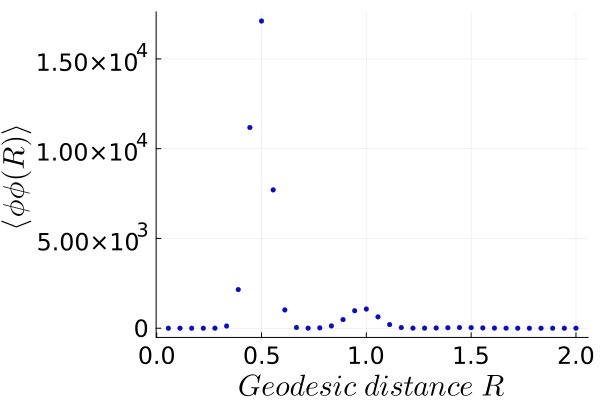

In [55]:
plot_correlation(d_vals, corr_vals)